In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Ship:
    def __init__(self, length, symbol, name):
        self.length = length
        self.symbol = symbol
        self.name = name

In [2]:
class GoodPlayer:
    def __init__(self, game, ship_types):
        self.game = game
        self.ship_types = ship_types
        self.ROWS, self.COLS = game.shape
        self.missed = []
        self.destroyed = []
        self.spot_prob = np.zeros((self.ROWS, self.COLS))
        self.state = 0 # Hunting
        self.moves = 0
        self.game_heat = np.array([[1 if ch != '.' else 0 for ch in row] for row in game])
        self.game_error = np.zeros((self.ROWS, self.COLS))
        
    def check_destroyed(self):
        for ship in self.ship_types:
            if not np.isin(ship.symbol, self.game):
                print(f'{ship.name} destroyed!')
                self.ship_types.remove(ship)
                return True
        return False
        
    def valid_position(self, row, col):
        if row < 0 or row >= self.ROWS or col < 0 or col >= self.COLS:
            return False
        if (row, col) in self.missed:
            return False
        return True
    
    def valid_place(self, row, col, length, direction):
        if not self.valid_position(row, col):
            return False
        if direction == 'v':
            for r in range(row, row + length):
                if not self.valid_position(r, col):
                    return False
            return True
        if direction == 'h':
            for c in range(col, col + length):
                if not self.valid_position(row, c):
                    return False
            return True
        
        return False
    
    def choose(self):
        if (self.state == 0):
            self.hunt_prob()
        if (self.state == 1):
            self.target_prob()
        
        # Modify error array
        m = self.spot_prob.max()
        for pos, value in np.ndenumerate(self.game_error):
            self.game_error[pos] = abs((self.spot_prob[pos]/m) - self.game_heat[pos]) * 100
        min_ = self.game_error.min()
        #self.game_error -= min_
        #self.plotError()
        
        max_ = 0
        point = (0, 0)
        points = []
        self.plot()
        for i, value in np.ndenumerate(self.spot_prob):
            if value == max_:
                if self.spot_prob[point] == max_:
                    points.append(point)
                points.append(i)
            if value > max_:
                points = []
                max_ = value
                point = i
        if len(points) > 0:
            return random.choice(points)
        return point
    
    def attack(self):
        if len(self.ship_types) == 0:
            self.hunt_prob()
            self.plot()
            print(f'Finished in {self.moves} moves!')
            return False
        self.moves += 1
        point = self.choose()
        print(point)
        if game[point] == '.':
            #print('Missed!')
            self.missed.append(point)
            self.game[point] = 'o'
        else:
            #print('Hit!')
            self.destroyed.append(point)
            self.game[point] = 'X'
            self.game_heat[point] = 0
            self.state = 1
        
        if self.check_destroyed():
            self.state = 0
            for point in self.destroyed:
                self.missed.append(point)
            self.destroyed = []
        return True
    
    def hunt_prob(self):
        self.spot_prob = np.zeros((self.ROWS, self.COLS))
        for ship in self.ship_types:
            for row in range(self.ROWS):
                for col in range(self.COLS):
                    # check cross hair
                    for i in range(row - ship.length + 1, row + 1):
                        if self.valid_place(i, col, ship.length, 'v'):
                            self.spot_prob[row, col] += 1
                    for i in range(col - ship.length + 1, col + 1):
                        if self.valid_place(row, i, ship.length, 'h'):
                            self.spot_prob[row, col] += 1
        # Parity (remove all even-odd odd-even positions)
        #for pos, value in np.ndenumerate(self.spot_prob):
        #    if (pos[0] % 2 == 0 and pos[1] % 2 == 1) or (pos[1] % 2 == 0 and pos[0] % 2 == 1):
        #        self.spot_prob[pos] = 0

    def target_prob(self):
        self.spot_prob = np.zeros((self.ROWS, self.COLS))
        for ship in self.ship_types:
            for row, col in self.destroyed:
                # For start position in crosshair
                for i in range(row - ship.length + 1, row + 1):
                    for j in range(i, i + ship.length):
                        if self.valid_position(j, col):
                            self.spot_prob[j, col] += 1
                for i in range(col - ship.length + 1, col + 1):
                    for j in range(i, i + ship.length):
                        if self.valid_position(row, j):
                            self.spot_prob[row, j] += 1
                        
        # Don't target destroyed spot
        for point in self.destroyed:
            self.spot_prob[point] = 0
            
    def plotError(self):
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.xticks(ticks=np.arange(self.COLS), labels=np.arange(self.COLS))
        plt.yticks(ticks=np.arange(self.ROWS), labels=np.arange(self.ROWS))
        plt.title('Probability Error')
        im = plt.imshow(self.game_error, cmap='gray', interpolation='nearest')
        plt.colorbar(im)
        for i in range(self.ROWS):
            for j in range(self.COLS):
                text = plt.text(j, i, f'{self.game_error[i][j]:.0f}',
                               ha="center", va="center", color="r")
        plt.show()
            
    def plot(self):
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.xticks(ticks=np.arange(self.COLS), labels=np.arange(self.COLS))
        plt.yticks(ticks=np.arange(self.ROWS), labels=np.arange(self.ROWS))
        plt.title('Battleship Probability Density')
        im = plt.imshow(self.spot_prob, cmap='binary', interpolation='nearest')
        plt.colorbar(im)
        for i in range(self.ROWS):
            for j in range(self.COLS):
                text = plt.text(j, i, f'{self.spot_prob[i][j]:.0f}',
                               ha="center", va="center", color="r")
        #plt.grid(color='gray', linestyle='-.', linewidth=1)
        plt.show()

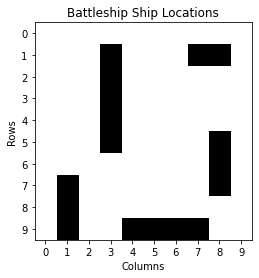

In [3]:
board = '''
..........
...A...DD.
...A......
...A......
...A......
...A....C.
........C.
.S......C.
.S........
.S..BBBB..
'''
boardHeatMap = np.array([[1 if ch != '.' else 0 for ch in row ] for row in board.lstrip('\n').rstrip('\n').split('\n')], dtype=int)
r, c = boardHeatMap.shape
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.xticks(ticks=np.arange(c), labels=np.arange(c))
plt.yticks(ticks=np.arange(r), labels=np.arange(r))
plt.title('Battleship Ship Locations')
im = plt.imshow(boardHeatMap, cmap='binary', interpolation='nearest')
#ax = plt.gca()
#plt.colorbar(im)
#plt.grid(color='gray', linestyle='-.', linewidth=1)
plt.savefig('shiplocation.png')

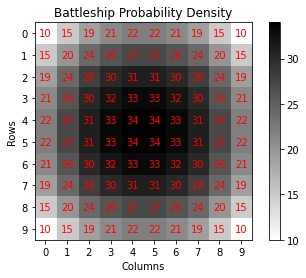

(5, 4)


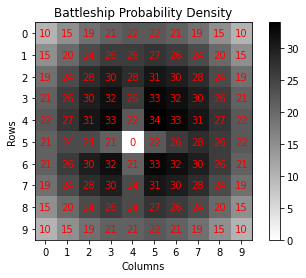

(4, 5)


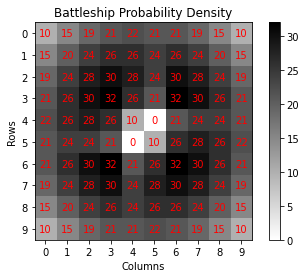

(6, 6)


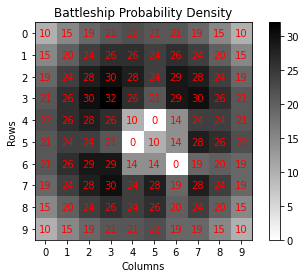

(3, 3)


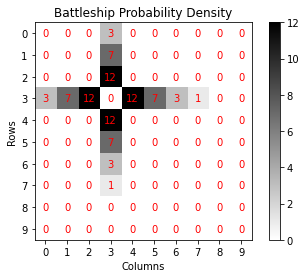

(4, 3)


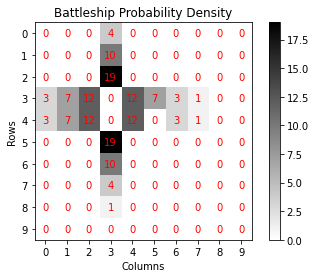

(2, 3)


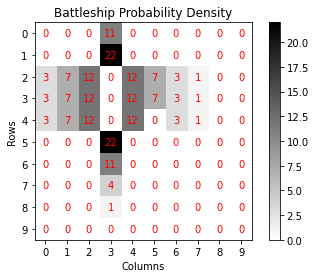

(5, 3)


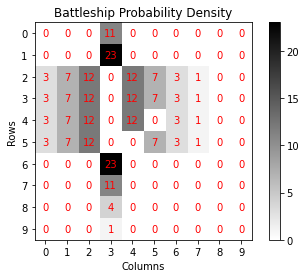

(1, 3)
aircraft carrier destroyed!


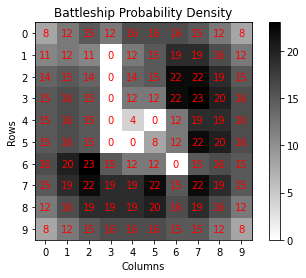

(6, 2)


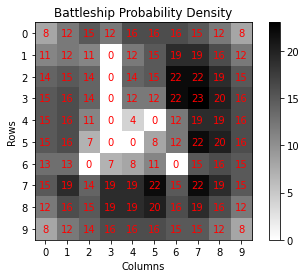

(3, 7)


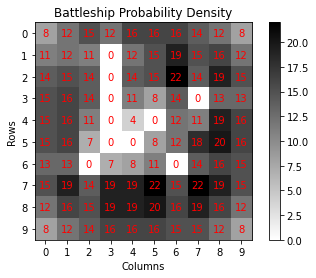

(2, 6)


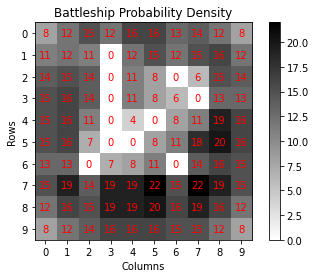

(7, 7)


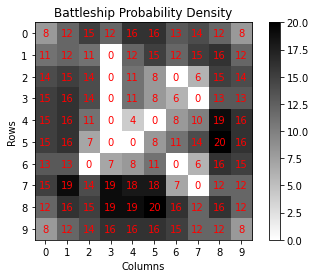

(5, 8)


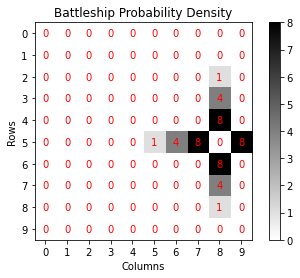

(6, 8)


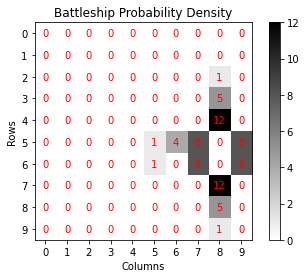

(4, 8)


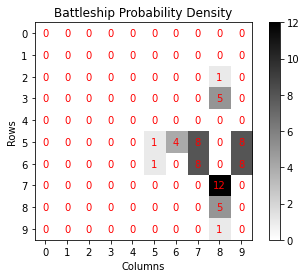

(7, 8)
cruiser destroyed!


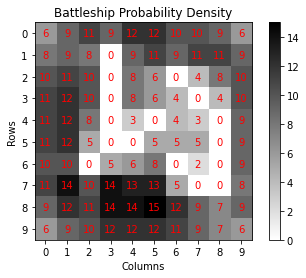

(8, 5)


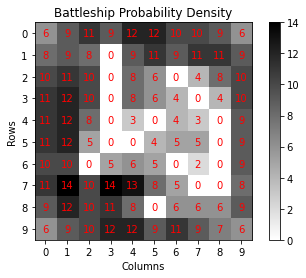

(7, 3)


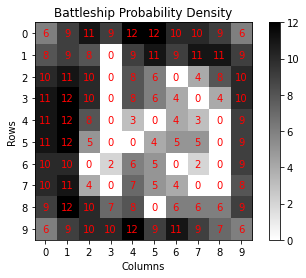

(0, 4)


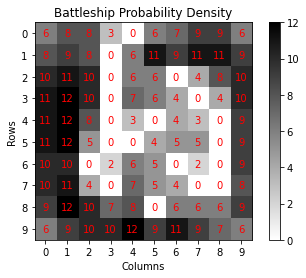

(3, 1)


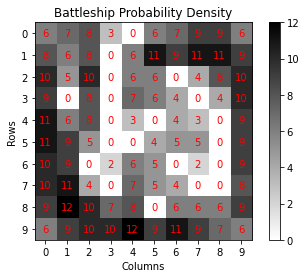

(9, 4)


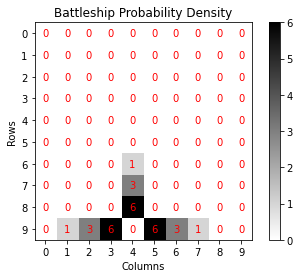

(9, 5)


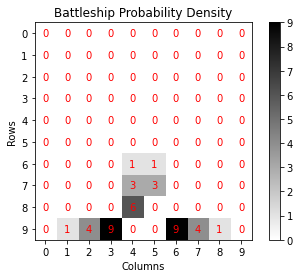

(9, 6)


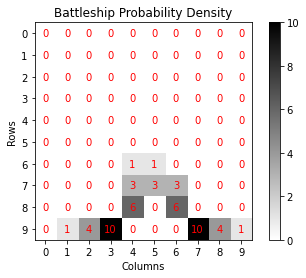

(9, 3)


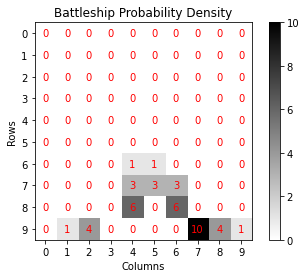

(9, 7)
battleship destroyed!


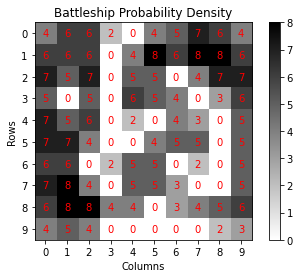

(1, 5)


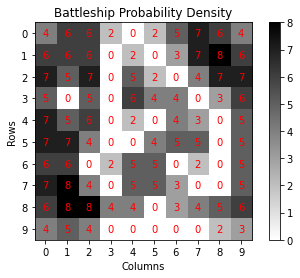

(1, 8)


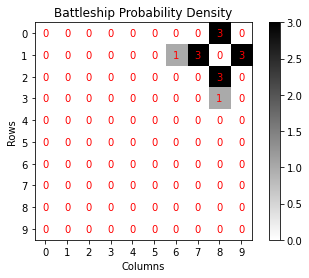

(1, 7)
destroyer destroyed!


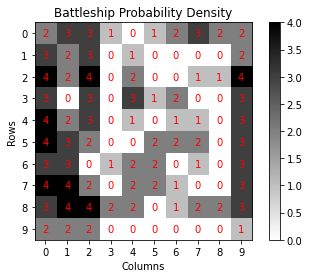

(4, 0)


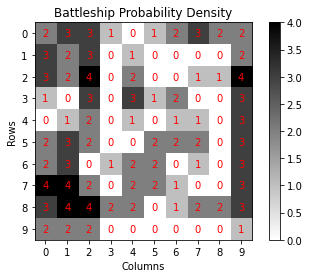

(8, 2)


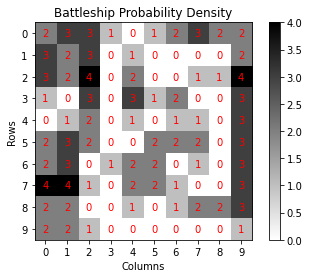

(7, 1)


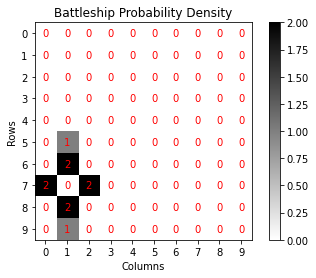

(6, 1)


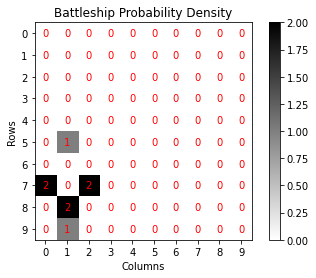

(7, 2)


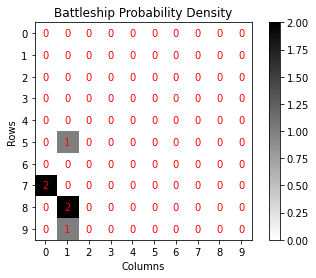

(8, 1)


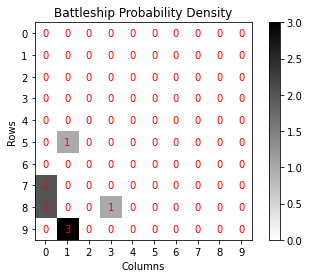

(9, 1)
submarine destroyed!


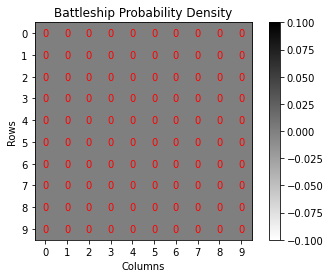

Finished in 35 moves!


In [4]:
board = '''
..........
...A...DD.
...A......
...A......
...A......
...A....C.
........C.
.S......C.
.S........
.S..BBBB..
'''
ship_types = [Ship(3, 'C', 'cruiser'), Ship(2, 'D', 'destroyer'), Ship(3, 'S', 'submarine'), Ship(4, 'B', 'battleship'), Ship(5, 'A', 'aircraft carrier')]
game = np.array([[ch for ch in row] for row in board.lstrip('\n').rstrip('\n').split('\n')])
p = GoodPlayer(game, ship_types)

o = 0
while (p.attack()):
    o += 0